## 04 16S and shotgun correlation

This notebook illustrates how the shotgun metagenomic species level information was matched for each OTU of interest as shown in [Figure 2A](assets/Figure_2A.tif) (and S3).
***

### 4.1 Clean environment. Load libraries.

In [1]:
rm(list = ls())

##-- load libs
suppressMessages(library(ggplot2))
suppressMessages(library(reshape2))
suppressMessages(library(ggcorrplot))

### 4.2 Define a custom function to identify shotgun bugs that potentially match to 16S OTUs and compute correlation matrix. 

In [2]:
calc.cor = function(df1, df2, key1, key2) {
  
  ##-- select 16S OTUs and shotgun species based on keys
  df1.flt = df1[key1,,drop=F]
  df2.flt = df2[grep(paste0('f__',key2,'[|]'),row.names(df2)),,drop=F]
  row.names(df2.flt) = 
    do.call(rbind.data.frame, (strsplit(row.names(df2.flt), '[|]')))[,7]
  print(nrow(df2.flt))
  
  ##-- prepare input for correlation
  my.df = merge(t(df1.flt), t(df2.flt),by = 'row.names')
  row.names(my.df) = my.df[,1]
  my.df = my.df[,-1]
  my.df = my.df[,which(colSums(my.df>0)>=3)]
  print(dim(my.df)) 
  print(colnames(my.df))
  
  ##-- compute a correlation matrix
  my.cor = round(cor(my.df, method = 'spearman'), 5)
  my.cor.sub = my.cor[!row.names(my.cor) %in% key1,
                      colnames(my.cor) %in% key1,drop=F]
  
  ##-- sort higher to lower
  my.cor.sub = my.cor.sub[rev(order(my.cor.sub[,1])),,drop=F] 
  
  ##-- filter for positive correlation only
  my.cor.sub = my.cor.sub[my.cor.sub[,1]>0,,drop=F] 
  
  return(my.cor.sub)
  
}

### 4.3 Import data files.

In [3]:
##-- data files
sample.file = '../data/human_16S.sampleinfo.csv'
otu.file = '../data/human_16S.even13190.rel.sig.csv'
shotgun.file = '../data/human_shotgun.rel.full.csv'
qpcr.file = '../data/human_16S_qPCR.csv'
stats.file = '../data/human_16S.even13190.stats.sig.csv'

##-- import data 
sample = read.csv(sample.file, row.names = 1)
otu = read.csv(otu.file, row.names = 1)
shotgun = read.csv(shotgun.file, row.names = 1)
qpcr = read.csv(qpcr.file, row.names = 1)
stats = read.csv(stats.file, row.names = 1, stringsAsFactors = F)

print(nrow(otu))

[1] 63


### 4.4 Taking Bifido bug (OTU 559527) as an example to show how the shotgun species were selected. Pairwise correlation coefficient was computed between each species and OTU of interest. 
Note that we first narrow down the list of species based on family level match to limit the number of tests. Only species that positively correlate with each OTU were selected for further analysis.

In [4]:
##-- first match 16S and shotgun bugs on family level

otu.id = '559527'
family = with(stats, Family.16S[row.names(stats)==otu.id])
print(family)

##-- make the function call to select shotgun species and compute correlation coefficient matrix
data.plot = calc.cor(otu, shotgun, paste0(otu.id,'|',family), family)

print(data.plot)

[1] "Bifidobacteriaceae"
[1] 15
[1] 39  9
[1] "559527|Bifidobacteriaceae"           
[2] "s__Alloscardovia_omnicolens"         
[3] "s__Bifidobacterium_adolescentis"     
[4] "s__Bifidobacterium_bifidum"          
[5] "s__Bifidobacterium_breve"            
[6] "s__Bifidobacterium_dentium"          
[7] "s__Bifidobacterium_longum"           
[8] "s__Bifidobacterium_pseudocatenulatum"
[9] "s__Scardovia_wiggsiae"               
                                     559527|Bifidobacteriaceae
s__Bifidobacterium_longum                              0.82789
s__Bifidobacterium_adolescentis                        0.76115
s__Bifidobacterium_breve                               0.37482
s__Alloscardovia_omnicolens                            0.34594
s__Bifidobacterium_pseudocatenulatum                   0.23857
s__Bifidobacterium_bifidum                             0.19538
s__Bifidobacterium_dentium                             0.13176
s__Scardovia_wiggsiae                                  0.03113


### 4.5 Draw correlation dotplot for OTUs and positively correlated shotgun species.

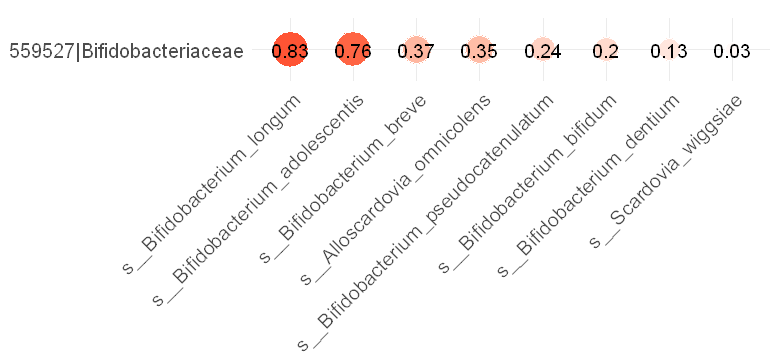

In [5]:
##-- set up R plot display options in notebook
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 6.5, repr.plot.height = 3)

##-- plot correlation matrix
p1 = ggcorrplot(data.plot, 
                method = 'circle',
                show.diag = FALSE,
                hc.order = FALSE, 
                show.legend = FALSE,
                hc.method = 'ward.D2',
                outline.color = '#FFFFFF',
                # p.mat = expr.corr.p,
                # insig = "blank",
                # sig.level = 0.05,
                type = "full",
                lab = TRUE)

print(p1)

In [6]:
sessionInfo()

R version 3.4.2 (2017-09-28)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 14393)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggcorrplot_0.1.1 reshape2_1.4.2   ggplot2_2.2.1   

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.13     magrittr_1.5     munsell_0.4.3    uuid_0.1-2      
 [5] colorspace_1.3-2 R6_2.2.2         rlang_0.1.4      stringr_1.2.0   
 [9] plyr_1.8.4       tools_3.4.2      grid_3.4.2       gtable_0.2.0    
[13] lazyeval_0.2.1   digest_0.6.12    tibble_1.3.4     crayon_1.3.4    
[17] IRdisplay_0.4.4  repr_0.12.0      IRkernel_0.8.9   evaluate_0.10.1 
[21] pbdZMQ_0.2-6     stringi_1.1.5    compile